# Interpretability of Language Model with Learning Interpretability Tool 🔥

## Overview

This notebook shows how to use explainability methods for a BERT-based text classification model with the [Learning Interpretability Tool (🔥LIT)](https://pair-code.github.io/lit/).

LIT is a visual, interactive ML model-understanding tool that supports text, image, and tabular data.<br>
You can use LIT to ask and answer questions like:
- What kind of examples does my model perform poorly on?
- Why did my model make this prediction? Can it attribute it to adversarial behavior, or undesirable priors from the training set?
- Does my model behave consistently if I change things like textual style, verb tense, or pronoun gender?

LIT contains many built-in capabilities but is also customizable, with the ability to add custom interpretability techniques, metrics calculations, counterfactual generators, visualizations, and more.

In this notebook, we'll explore the built-in interpretability methods - LIME, Gradient Norm, Gradient-dot-Input, and Integrated Gradients.

### Learning objectives: 
* Learn the overview of the Learning Interpretability Tool🔥
* Configure the LIT dataset and Model objects.
* Customize the Model for interpretability methods

In [1]:
# !pip install tensorflow==2.14.1 lit-nlp keras_nlp

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import datetime
import shutil
from collections.abc import Iterable, Sequence

import keras
import keras_nlp
import tensorflow as tf
from lit_nlp import notebook
from lit_nlp.api import dataset as lit_dataset
from lit_nlp.api import layout
from lit_nlp.api import model as lit_model
from lit_nlp.api import types as lit_types

# import tensorflow_text as text


JsonDict = lit_types.JsonDict
Spec = lit_types.Spec

tf.get_logger().setLevel("ERROR")

2024-09-06 13:14:12.008610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 13:14:12.008658: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 13:14:12.008695: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


## Build a BERT-based Sentiment Analysis model

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

path = "/home/jupyter/"
dataset = keras.utils.get_file(
    "aclImdb_v1.tar.gz", url, untar=True, cache_dir=path, cache_subdir=""
)

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

train_dir = os.path.join(dataset_dir, "train")

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    path + "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    path + "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    path + "aclImdb/test", batch_size=batch_size
)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


## Train BERT model with Keras NLP

For the purpose of this lab, we will be loading a small model called tiny BERT, already pre-trained for sentiment analysis purpose. The tiny BERT has the same general architecture as the original BERT but the has fewer and/or smaller Transformer blocks.

For other model types, see the [Keras NLP documentation](https://keras.io/api/keras_nlp/models/bert/bert_classifier/).

In [6]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased_sst2",
)

We use adamw optimizer with a warm-up period. See [this paper](https://arxiv.org/abs/1905.05583) for a general guideline of BERT finetuning

In [7]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

warmup_tgt = 3e-5
scheduler = tf.keras.optimizers.schedules.CosineDecay(
    0.0,
    num_train_steps,
    warmup_target=warmup_tgt,
    warmup_steps=num_warmup_steps,
)

optimizer = tf.keras.optimizers.AdamW(learning_rate=scheduler)

In [8]:
classifier.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.metrics.SparseCategoricalAccuracy()],
)

In [9]:
FILE_PATH = "./model"

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    FILE_PATH,
    monitor="val_loss",
    save_best_only=True,
)

history = classifier.fit(
    x=train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint_cb]
)

Epoch 1/5
625/625 [==============================] - 101s 145ms/step - loss: 0.3972 - sparse_categorical_accuracy: 0.8220 - val_loss: 0.3382 - val_sparse_categorical_accuracy: 0.8574
Epoch 2/5
625/625 [==============================] - 59s 95ms/step - loss: 0.3132 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.3093 - val_sparse_categorical_accuracy: 0.8696
Epoch 3/5
625/625 [==============================] - 56s 90ms/step - loss: 0.2743 - sparse_categorical_accuracy: 0.8877 - val_loss: 0.2977 - val_sparse_categorical_accuracy: 0.8774
Epoch 4/5
625/625 [==============================] - 57s 92ms/step - loss: 0.2488 - sparse_categorical_accuracy: 0.9004 - val_loss: 0.2976 - val_sparse_categorical_accuracy: 0.8818
Epoch 5/5
625/625 [==============================] - 50s 80ms/step - loss: 0.2312 - sparse_categorical_accuracy: 0.9082 - val_loss: 0.2984 - val_sparse_categorical_accuracy: 0.8800


---

## Use the Learning Interpretability Tool

Let's start using the Learning Interpretability Tool. We use LIT for our Keras model, but please note that LIT itself is framework agnostic.

<img src="https://pair-code.github.io/lit/documentation/_images/lit-system-diagram.svg" width="1084">

In this notebook, We'll configure two LIT objects: Dataset and Model.

### Dataset
Datasets are lists of examples, with associated type information following LIT’s type system.

- `spec()` should return a flat dict that describes the fields in each example. Note that each item is typed using Lit types. See [the documentation about the Lit types](https://pair-code.github.io/lit/documentation/api.html#available-types) for more details.
- `self._examples` should be a list of flat dicts, conforming to `spec()`

LIT operates on all examples loaded in the datasets you include in your LIT server. Therefore, you should take care to use dataset sizes that can fit into memory on your backend server and can be displayed in the browser.

Implementations should subclass [Dataset](https://github.com/PAIR-code/lit/blob/main/lit_nlp/api/dataset.py). Usually, this is just a few lines of code like the example below.

In [28]:
NUM_DATA = 100  # Get small samples
LABELS = ["negative", "positive"]


class ImdbSentimentData(lit_dataset.Dataset):

    def __init__(self, dataset: tf.data.Dataset):
        data_array = list(
            dataset.shuffle(dataset.cardinality()).as_numpy_iterator()
        )
        texts, labels = [], []
        for fs, ls in data_array:
            texts.extend([f.decode() for f in fs if len(f.decode())])
            labels.extend(ls)
        # Store as a list of dicts, conforming to self.spec()
        self._examples = [
            {
                "text": text,
                "label": LABELS[1] if label else LABELS[0],
            }
            for text, label in zip(texts[:NUM_DATA], labels[:NUM_DATA])
        ]

    def spec(self):
        return {
            "text": lit_types.TextSegment(),
            "label": lit_types.CategoryLabel(vocab=LABELS),
        }

### Model

Models are functions that take inputs and produce outputs, with associated type information following LIT’s type system. 

The core API consists of three methods:
- `input_spec()` should return a flat dict that describes necessary input fields. Here we define `"text"` and `"label"`.
- `output_spec()` should return a flat dict that describes the model’s predictions and any additional outputs. In our case, we use the `MulticlassPreds` type.
- `predict()` should take a sequence of inputs (satisfying `input_spec()`) and yields a parallel sequence of outputs matching `output_spec()`.

Implementations should subclass [Model](https://github.com/PAIR-code/lit/blob/main/lit_nlp/api/model.py). 

With this simple Model setup, we can use a black box interpretability method, LIME, since it just pays attention to inputs and outputs.

In [29]:
class BertSentimentModel(lit_model.Model):

    def __init__(self, model: tf.keras.Model):
        self._model = model

    def predict(self, inputs: Iterable[JsonDict]) -> Iterable[JsonDict]:
        examples = [d["text"] for d in inputs]
        tokens = self._model.preprocessor(examples)
        logits = self._model(tokens)
        probs = tf.keras.activations.sigmoid(logits)
        return [{"prob": prob.numpy()} for prob in probs]

    def input_spec(self) -> Spec:
        return {
            "text": lit_types.TextSegment(),
            "label": lit_types.CategoryLabel(required=False, vocab=LABELS),
        }

    def output_spec(self) -> Spec:
        return {
            "prob": lit_types.MulticlassPreds(vocab=LABELS, parent="label"),
        }

Now let's create a LIT widget in the notebook.

In [41]:
# Create the LIT widget with the model and dataset to analyze.
datasets = {"acllmdb": ImdbSentimentData(test_ds)}
models = {"BERT classifier": BertSentimentModel(classifier)}
layouts = {"default": "default"}

# Uncomment below when you rerun the widget.
widget.stop()
widget = notebook.LitWidget(models, datasets, port=8890)

::1 - - [06/Sep/2024 13:46:27] "POST /get_info HTTP/1.1" 200 24099
::1 - - [06/Sep/2024 13:46:28] "POST /get_dataset?dataset_name=acllmdb HTTP/1.1" 200 162449
::1 - - [06/Sep/2024 13:46:28] "POST /get_interpretations?model=BERT%20classifier&dataset_name=acllmdb&interpreter=classification&do_predict=1 HTTP/1.1" 200 17463
::1 - - [06/Sep/2024 13:46:28] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
::1 - - [06/Sep/2024 13:46:28] "POST /get_metrics?model=BERT%20classifier&dataset_name=acllmdb&metrics=multiclass,paired&do_predict=1 HTTP/1.1" 200 162
::1 - - [06/Sep/2024 13:46:30] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
::1 - - [06/Sep/2024 13:46:30] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
::1 - - [06/Sep/2024 13:46:31] "POST /get_preds?model=BERT%20classifier&dataset_name=acllmdb&requested_types=MulticlassPreds,RegressionScore&requested_fields= HTTP/1.1" 200 53
::1 - - [06/Sep/2024 13:46:35] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 

You can render the widget using the `render()` method.<br>
The widget can be embedded in the notebook, but let's add `open_in_new_tab=True` and check the widget on another tab.

Feel free to play around with the UI and check how the concepts we defined above are linked to the LIT UI.

In [42]:
# Render the widget
widget.render(height=600, open_in_new_tab=True)

### Customize the Layout

The UI looks handy, isn't it?<br>
But you might want to change the layout a bit. No worries! The LIT UI is customizable.<br>

Let's switch to a richer layout from the prebuild layout catalog. <br>
We'll keep the original UI in case you want to switch back by passing multiple layouts in a dictionary.


In [71]:
layouts = {
    "rich_layout": layout.THREE_PANEL_LAYOUT,
    "default": notebook.LIT_NOTEBOOK_LAYOUT,
}

In [72]:
widget.stop()
widget = notebook.LitWidget(models, datasets, layouts=layouts, port=8890)
widget.render(height=600, open_in_new_tab=True)

::1 - - [06/Sep/2024 14:29:40] "GET /main.js HTTP/1.1" 200 2024211
::1 - - [06/Sep/2024 14:29:41] "GET /static/favicon.png HTTP/1.1" 200 13257
::1 - - [06/Sep/2024 14:29:41] "POST /get_info HTTP/1.1" 200 26045
::1 - - [06/Sep/2024 14:29:42] "POST /get_dataset?dataset_name=acllmdb HTTP/1.1" 200 162449
::1 - - [06/Sep/2024 14:29:42] "GET /static/onboarding_1_welcome.gif HTTP/1.1" 200 584363
::1 - - [06/Sep/2024 14:29:42] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
::1 - - [06/Sep/2024 14:29:43] "POST /get_metrics?model=BERT%20classifier&dataset_name=acllmdb&metrics=multiclass,paired&do_predict=1 HTTP/1.1" 200 162
::1 - - [06/Sep/2024 14:29:43] "POST /get_interpretations?model=BERT%20classifier&dataset_name=acllmdb&interpreter=classification&do_predict=1 HTTP/1.1" 200 17463
::1 - - [06/Sep/2024 14:29:46] "POST /get_metrics?model=BERT%20classifier&dataset_name=acllmdb&metrics=multiclass,paired&do_predict=1 HTTP/1.1" 200 162
::1 - - [06/Sep/2024 14:29:47] "POST /get_metrics?mo

If you want to customize the UI, refer to the [documentation](https://pair-code.github.io/lit/documentation/api.html#customizing-the-layout) and the [UI definition](https://github.com/PAIR-code/lit/blob/main/lit_nlp/api/layout.py#L173) we just used.

### Explore the LIME explanation
Now, let's investigate the LIME explanation using the UI we just rendered.

[LIME](https://arxiv.org/abs/1602.04938) is a widely used black box (or model-agnostic) explainability method. Since it is a black box method, we can use LIME for any ML models (or, more generally, any functions that have inputs and outputs) to get the saliency.

1. Select a text input from the left panel.
2. On the upper-right panel, check the predicted probabilities for the `negative` and `positive` classes, the label (indicated as `T`), and the predicted class (`P`).
3. On the lower right panel, select the `Explanations` tab.
4. Click the arrow symbol on the right-hand side of `LIME.`
5. Saliency scores appear on each word. If the coloring is too pale, raise the `Gamma` score until you can see the color clearly.
6. Confirm that the predicted class is already set as `Class to explain`.
6. Mouse over an important word (colored in a vivid red or blue color), and check the score. A positive score means a positive contribution to the label (to the `positive` class in the screenshot below), and a negative score means a negative contribution.

<img width="800" src="https://github.com/user-attachments/assets/05623753-bdf8-4aec-88c6-3e7d0718576a">


---

## Add Gradient-based Saliency Methods


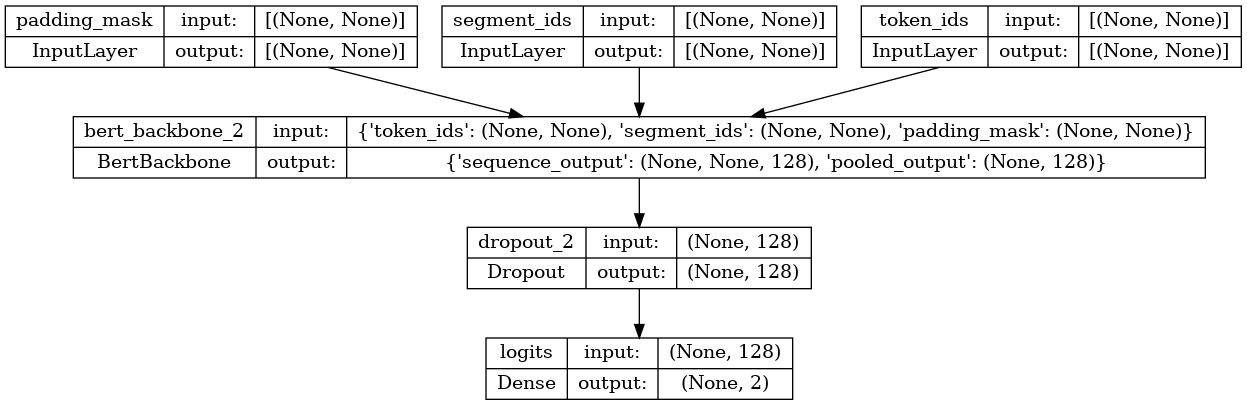

In [133]:
tf.keras.utils.plot_model(classifier, show_shapes=True, show_layer_names=True)

In [124]:
classifier.layers

In [32]:
classifier.layers[3].layers

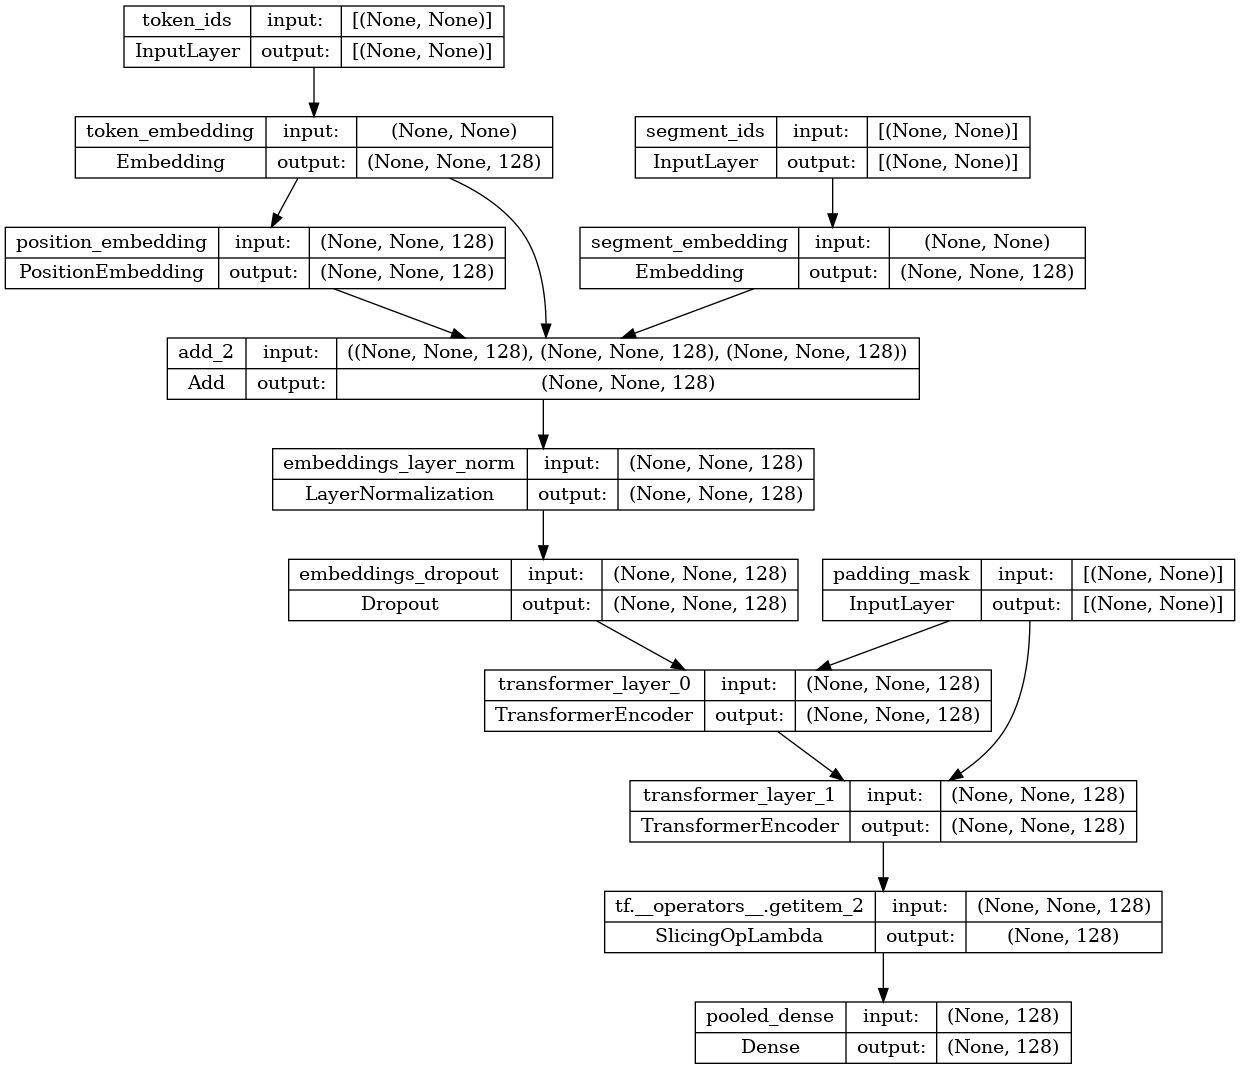

In [137]:
tf.keras.utils.plot_model(
    classifier.layers[3], show_shapes=True, show_layer_names=True
)

In [34]:
embedding_model = tf.keras.Model(
    inputs=classifier.input, outputs=classifier.layers[3].layers[6].output
)

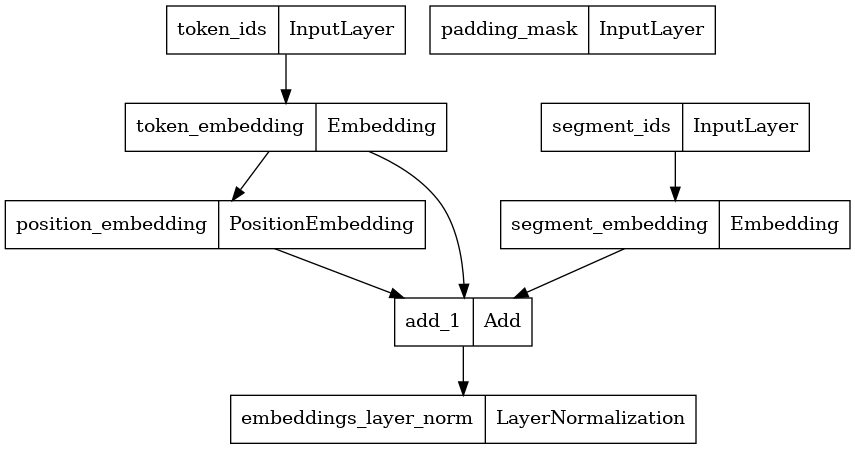

In [35]:
tf.keras.utils.plot_model(embedding_model)

In [229]:
bert_backbone = tf.keras.Model(
    inputs=[
        classifier.layers[3].layers[7].input,
        classifier.layers[3].layers[8].input,
    ],
    outputs=classifier.layers[3].layers[-1].output,
)

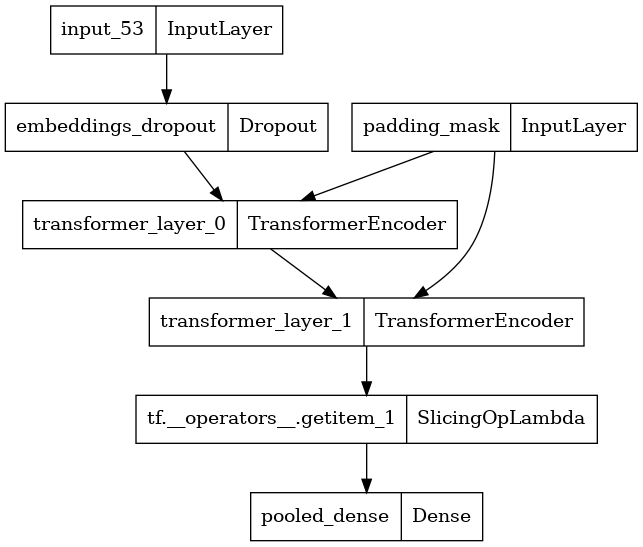

In [230]:
tf.keras.utils.plot_model(bert_backbone)

In [231]:
cls_head = tf.keras.Model(
    inputs=classifier.layers[-2].input, outputs=classifier.layers[-1].output
)

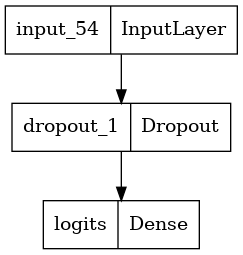

In [232]:
tf.keras.utils.plot_model(cls_head)

In [245]:
tokens = classifier._preprocessor(tf.constant(texts[:1]))
embedding = embedding_model(tokens)
bert_output = bert_backbone([embedding, tokens["padding_mask"]])
logits = cls_head(bert_output)
logits

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.05474576, 0.09981707]], dtype=float32)>

In [246]:
tokens = classifier._preprocessor(tf.constant(texts[:1]))
embeddings = embedding_model(tokens)
with tf.GradientTape() as tape:
    tape.watch(embeddings)
    bert_output = bert_backbone([embeddings, tokens["padding_mask"]])
    logits = cls_head(bert_output)

    indices = tf.argmax(logits, axis=-1)
    pred = tf.gather_nd(logits, [[i, idx] for i, idx in enumerate(indices)])

input_emb_grads = tape.gradient(pred, embeddings)
input_emb_grads

<tf.Tensor: shape=(1, 512, 128), dtype=float32, numpy=
array([[[ 2.5211675e-03, -3.2409839e-02, -6.9019878e-03, ...,
          2.7296547e-02,  4.5807930e-03,  1.4555874e-02],
        [-9.9885708e-04, -2.8899801e-03,  4.8571019e-03, ...,
          1.7197364e-03,  6.7635463e-03,  2.8126221e-03],
        [-1.0863496e-03, -1.4005759e-03, -4.5379478e-05, ...,
         -5.9404876e-05,  2.2665113e-03,  1.7321140e-03],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]], dtype=float32)>

In [193]:
START_OFFSET = 1
END_OFFSET = 1


class BertSentimentModel(lit_model.Model):

    def __init__(self, model):
        self._model = model
        self._embedding_model = tf.keras.Model(
            inputs=model.input, outputs=model.layers[3].layers[6].output
        )
        self._bert_backbone = tf.keras.Model(
            inputs=[
                model.layers[3].layers[7].input,
                model.layers[3].layers[8].input,
            ],
            outputs=model.layers[3].layers[-1].output,
        )
        self._cls_head = tf.keras.Model(
            inputs=classifier.layers[-2].input,
            outputs=classifier.layers[-1].output,
        )

    def _detokenize(self, indices):
        return [
            self._model.preprocessor.tokenizer.vocabulary[idx]
            for idx in indices
        ]

    def predict(self, inputs):
        """Predict on a stream of examples."""
        examples = [d["text"] for d in inputs]
        tokenized = self._model.preprocessor(examples)
        seq_lens = tf.reduce_sum(
            tf.cast(tokenized["padding_mask"], tf.int32), axis=-1
        )
        embeddings = self._embedding_model(tokenized)
        with tf.GradientTape() as tape:
            tape.watch(embeddings)
            bert_output = self._bert_backbone(
                [embeddings, tokenized["padding_mask"]]
            )
            logits = self._cls_head(bert_output)

            if "label" in inputs[0].keys():
                indices = [
                    1 if inp["label"] == LABELS[1] else 0 for inp in inputs
                ]
            else:
                indices = tf.argmax(logits, axis=-1)

            pred = tf.gather_nd(
                logits, [[i, idx] for i, idx in enumerate(indices)]
            )

        probs = tf.keras.activations.softmax(logits)

        input_emb_grads = tape.gradient(pred, embeddings)

        return [
            {
                "prob": [prob.numpy()[1], prob.numpy()[0]],
                "tokens": self._detokenize(
                    tokens[START_OFFSET : slen - END_OFFSET]
                ),
                "input_embedding": emb[
                    START_OFFSET : slen - END_OFFSET
                ].numpy(),
                "input_emb_grad": grad[
                    START_OFFSET : slen - END_OFFSET
                ].numpy(),
            }
            for prob, tokens, emb, grad, slen in zip(
                probs,
                tokenized["token_ids"],
                embeddings,
                input_emb_grads,
                seq_lens,
            )
        ]

    def input_spec(self):
        """Describe the inputs to the model."""
        return {
            "text": lit_types.TextSegment(),
            "label": lit_types.CategoryLabel(required=False, vocab=LABELS),
        }

    def output_spec(self):
        """Describe the model outputs."""
        return {
            "prob": lit_types.MulticlassPreds(vocab=LABELS, parent="label"),
            "tokens": lit_types.Tokens(parent="text"),
            "input_embedding": lit_types.TokenEmbeddings(align="tokens"),
            "input_emb_grad": lit_types.TokenGradients(
                align="tokens", grad_for="input_embedding"
            ),
        }

In [194]:
# Create the LIT widget with the model and dataset to analyze.
datasets = {"acllmdb": BertSentimentModel(test_ds)}
models = {"BERT classifier": LITBertModel(classifier)}

widget.stop()
widget = notebook.LitWidget(models, datasets, port=8890)

::1 - - [05/Sep/2024 13:53:29] "POST /get_info HTTP/1.1" 200 24667
::1 - - [05/Sep/2024 13:53:29] "POST /get_dataset?dataset_name=acllmdb HTTP/1.1" 200 154508
::1 - - [05/Sep/2024 13:53:30] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
::1 - - [05/Sep/2024 13:53:37] "POST /get_metrics?model=BERT%20classifier&dataset_name=acllmdb&metrics=multiclass,paired&do_predict=1 HTTP/1.1" 200 162
::1 - - [05/Sep/2024 13:53:37] "POST /get_interpretations?model=BERT%20classifier&dataset_name=acllmdb&interpreter=classification&do_predict=1 HTTP/1.1" 200 17520
::1 - - [05/Sep/2024 13:53:49] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4


In [195]:
widget.render(height=600)

## Add Integrated Gradients

In [218]:
START_OFFSET = 1  # offset [CLS] token
END_OFFSET = 1  # offset [SEP] token


class BertSentimentModel(lit_model.Model):

    def __init__(self, model):
        self._model = model
        self._embedding_model = tf.keras.Model(
            inputs=model.input, outputs=model.layers[3].layers[6].output
        )
        self._bert_backbone = tf.keras.Model(
            inputs=[
                model.layers[3].layers[7].input,
                model.layers[3].layers[8].input,
            ],
            outputs=model.layers[3].layers[-1].output,
        )
        self._cls_head = tf.keras.Model(
            inputs=classifier.layers[-2].input,
            outputs=classifier.layers[-1].output,
        )

    def _detokenize(self, indices):
        return [
            self._model.preprocessor.tokenizer.vocabulary[idx]
            for idx in indices
        ]

    def predict(self, inputs):
        """Predict on a stream of examples."""
        examples = [d["text"] for d in inputs]
        tokenized = self._model.preprocessor(examples)
        seq_lens = tf.reduce_sum(
            tf.cast(tokenized["padding_mask"], tf.int32), axis=-1
        )
        embeddings = self._embedding_model(tokenized)
        if "input_embedding" in inputs[0].keys():
            pertubations = tf.convert_to_tensor(
                [inp["input_embedding"] for inp in inputs]
            )
            step_size, ptb_len, emd_dim = pertubations.shape
            pertubations = tf.reshape(
                pertubations, (step_size * ptb_len, emd_dim)
            )
            update_indices = [
                [s, l + START_OFFSET]
                for s in range(step_size)
                for l in range(ptb_len)
            ]
            embeddings = tf.tensor_scatter_nd_update(
                embeddings, update_indices, pertubations
            )
        with tf.GradientTape() as tape:
            tape.watch(embeddings)
            bert_output = self._bert_backbone(
                [embeddings, tokenized["padding_mask"]]
            )
            logits = self._cls_head(bert_output)
            if "label" in inputs[0].keys():
                indices = [
                    1 if inp["label"] == LABELS[1] else 0 for inp in inputs
                ]
            else:
                indices = tf.argmax(logits, axis=-1)
            pred = tf.gather_nd(
                logits, [[i, idx] for i, idx in enumerate(indices)]
            )

        probs = tf.keras.activations.softmax(logits)

        input_emb_grads = tape.gradient(pred, embeddings)

        return [
            {
                "prob": [prob.numpy()[1], prob.numpy()[0]],
                "tokens": self._detokenize(
                    tokens[START_OFFSET : slen - END_OFFSET]
                ),
                "input_embedding": emb[
                    START_OFFSET : slen - END_OFFSET
                ].numpy(),
                "input_emb_grad": grad[
                    START_OFFSET : slen - END_OFFSET
                ].numpy(),
            }
            for prob, tokens, emb, grad, slen in zip(
                probs,
                tokenized["token_ids"],
                embeddings,
                input_emb_grads,
                seq_lens,
            )
        ]

    def input_spec(self):
        """Describe the inputs to the model."""
        return {
            "text": lit_types.TextSegment(),
            "label": lit_types.CategoryLabel(required=False, vocab=LABELS),
            "input_embedding": lit_types.TokenEmbeddings(
                required=False, align="tokens"
            ),
        }

    def output_spec(self):
        """Describe the model outputs."""
        return {
            "prob": lit_types.MulticlassPreds(vocab=LABELS, parent="label"),
            "tokens": lit_types.Tokens(parent="text"),
            "input_embedding": lit_types.TokenEmbeddings(align="tokens"),
            "input_emb_grad": lit_types.TokenGradients(
                align="tokens",
                grad_for="input_embedding",
                grad_target_field_key="label",
            ),
        }

In [219]:
# Create the LIT widget with the model and dataset to analyze.
datasets = {"acllmdb": LITSentimentData(test_ds)}
models = {"BERT classifier": BertSentimentModel(classifier)}

widget.stop()
widget = notebook.LitWidget(models, datasets, port=8890)

::1 - - [05/Sep/2024 14:14:38] "POST /get_info HTTP/1.1" 200 24845
::1 - - [05/Sep/2024 14:14:38] "POST /get_dataset?dataset_name=acllmdb HTTP/1.1" 200 154508
::1 - - [05/Sep/2024 14:14:45] "POST /get_metrics?model=BERT%20classifier&dataset_name=acllmdb&metrics=multiclass,paired&do_predict=1 HTTP/1.1" 200 162
::1 - - [05/Sep/2024 14:14:45] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
::1 - - [05/Sep/2024 14:14:45] "POST /get_interpretations?model=BERT%20classifier&dataset_name=acllmdb&interpreter=classification&do_predict=1 HTTP/1.1" 200 17520


In [220]:
widget.render(height=600)

In [217]:
from lit_nlp.components import gradient_maps

ig = gradient_maps.IntegratedGradients()

ig_results = ig.run(
    LITSentimentData(test_ds).examples[:1],
    LITBertModel(classifier),
    LITSentimentData(test_ds),
)
ig_results

[{'input_emb_grad': TokenSalience(tokens=['i', 'think', 'dirty', 'dancing', 'was', 'a', 'great', 'movie', ',', 'they', 'tried', 'to', 'make', 'another', 'one', 'havana', 'nights', 'which', 'was', 'good', 'but', 'it', 'was', 'nothing', 'like', 'dirty', 'dancing', '.', 'i', 'would', 'like', 'to', 'see', 'another', 'dirty', 'dancing', 'with', 'the', 'same', 'people', '.', 'without', 'them', 'i', 'think', 'it', 'would', 'be', 'a', 'mess', '.', 'a', 'lot', 'of', 'times', 'movies', 'are', 'made', 'then', 'when', 'they', 'try', 'to', 'add', 'on', 'more', 'they', 'start', 'to', 'change', 'the', 'people', 'an', 'make', 'the', 'movies', 'go', 'down', 'hill', '.', 'i', 'would', 'love', 'to', 'see', 'dirty', 'dancing', 'have', 'another', 'one', 'to', 'see', 'what', 'happened', 'after', 'they', 'were', 'able', 'to', 'be', 'together', '.', 'patrick', 'an', 'jennifer', 'did', 'so', 'well', 'together', '.', 'this', 'movie', 'was', 'made', 'in', '1997', 'its', 'time', 'to', 'make', 'another', 'one', '.

In [330]:
df = pd.DataFrame(
    [
        ig_results[0]["input_emb_grad"].tokens,
        ig_results[0]["input_emb_grad"].salience,
    ],
    index=["token", "salience"],
)

salience_series = ig_results[0]["input_emb_grad"].salience
abs_max = max(abs(salience_series.max()), abs(salience_series.min()))
df.style.background_gradient(
    axis=1,
    gmap=df.loc["salience", :].apply(pd.to_numeric),
    vmin=-abs_max,
    vmax=abs_max,
    cmap="seismic",
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138
token,i,think,dirty,dancing,was,a,great,movie,",",they,tried,to,make,another,one,havana,nights,which,was,good,but,it,was,nothing,like,dirty,dancing,.,i,would,like,to,see,another,dirty,dancing,with,the,same,people,.,without,them,i,think,it,would,be,a,mess,.,a,lot,of,times,movies,are,made,then,when,they,try,to,add,on,more,they,start,to,change,the,people,an,make,the,movies,go,down,hill,.,i,would,love,to,see,dirty,dancing,have,another,one,to,see,what,happened,after,they,were,able,to,be,together,.,patrick,an,jennifer,did,so,well,together,.,this,movie,was,made,in,1997,its,time,to,make,another,one,.,but,this,time,start,where,it,left,off,an,keep,the,same,people,in,it,.
salience,0.014261,-0.002992,-0.004922,0.004781,-0.005915,0.006495,0.030867,-0.003785,0.006632,0.007742,-0.039481,0.004610,-0.004976,-0.003500,0.001578,0.016113,0.002132,0.000228,-0.005390,0.011774,0.002035,0.012808,-0.005836,-0.027479,0.001626,-0.002677,0.007186,0.001948,0.010695,-0.011365,-0.003171,0.005458,0.012721,-0.001787,-0.008362,0.002474,0.009434,0.006574,-0.019470,-0.001208,0.002534,0.005287,0.003309,0.009682,-0.003376,0.014403,-0.007815,0.002027,0.004974,-0.088144,0.000333,0.002337,0.002136,0.003715,0.004052,0.006119,0.001460,-0.004209,-0.003757,-0.002320,0.007668,-0.007009,0.004578,-0.003606,0.007327,0.003783,0.009104,-0.010196,0.005207,-0.005893,0.006843,-0.000258,0.004638,-0.007329,0.005731,0.008050,0.003881,-0.008273,0.002511,0.000535,0.012032,-0.014477,0.019099,0.004208,0.013227,-0.005983,0.004206,-0.002678,-0.004822,0.002676,0.004588,0.012174,0.009509,-0.001103,0.001795,0.007059,-0.018109,0.009168,0.003942,0.000978,0.007944,0.000048,0.004205,0.005074,-0.002416,-0.002398,-0.006378,0.015768,0.007374,0.000037,0.000148,-0.007075,-0.007051,-0.006161,0.006151,0.006127,0.006926,0.002147,0.003812,-0.006555,-0.004629,0.002481,-0.000619,0.001660,0.001191,0.003227,-0.004275,-0.001467,0.015433,-0.034444,-0.007499,0.003535,0.008670,0.004167,-0.015571,0.001243,0.005982,0.011249,0.000131
